## 1. Load Fire Perimeters and EJI Data

In [51]:
import geopandas as gpd
import os as os
import matplotlib.pyplot as plt
import contextily as ctx

os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

In [10]:
eji = gpd.read_file("data/EJI_California/EJI_2024_California.gdb")

In [7]:
palisades = gpd.read_file("data/palisades")
eaton = gpd.read_file("data/eaton")

In [11]:
eji.head()

,OBJECTID,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,GEOID_2020,COUNTY,StateDesc,STATEABBR,...,TWOMORE,E_TWOMORE,OTHERRACE,E_OTHERRACE,Tribe_PCT_Tract,Tribe_Names,Tribe_Flag,Shape_Length,Shape_Area,geometry
0,11620,06,077,005127,140000US06077005127,06077005127,06077005127,San Joaquin County,California,CA,...,408.0,5.4,0.0,0.0,0.0,-999,-999,5909.703135,1.962577e+06,"MULTIPOLYGON (((-2178538.439 328974.247, -2178..."
1,11557,06,077,003406,140000US06077003406,06077003406,06077003406,San Joaquin County,California,CA,...,203.0,5.4,0.0,0.0,0.0,-999,-999,3805.322542,8.541741e+05,"MULTIPOLYGON (((-2174646.947 350500.600, -2174..."
2,11594,06,077,004402,140000US06077004402,06077004402,06077004402,San Joaquin County,California,CA,...,132.0,2.2,0.0,0.0,0.0,-999,-999,8576.416378,4.345421e+06,"MULTIPOLYGON (((-2169306.156 358323.611, -2169..."
3,11617,06,077,005124,140000US06077005124,06077005124,06077005124,San Joaquin County,California,CA,...,161.0,4.8,0.0,0.0,0.0,-999,-999,4842.265671,1.085207e+06,"MULTIPOLYGON (((-2174819.146 325432.172, -2174..."
4,11509,06,077,001700,140000US06077001700,06077001700,06077001700,San Joaquin County,California,CA,...,160.0,3.8,0.0,0.0,0.0,-999,-999,5087.384776,1.686400e+06,"MULTIPOLYGON (((-2172633.856 343802.277, -2172..."


## Polygon intersection

Find intersection of census tracts for both the Eaton and Palisades fires.

In [27]:
# Transform 
palisades = palisades.to_crs(eji.crs)

# Inner join palisades perimeter to CA census tracts
palisades_tracts = gpd.sjoin(eji, palisades, how = "inner", predicate = "intersects")

In [ ]:
# Transform 
eaton = eaton.to_crs(eji.crs)

# Inner join palisades perimeter to CA census tracts
eaton_tracts = gpd.sjoin(eji, eaton, how = "inner", predicate = "intersects")

Plot both census tracts and their associated perimeters on the same plot.

<Axes: >

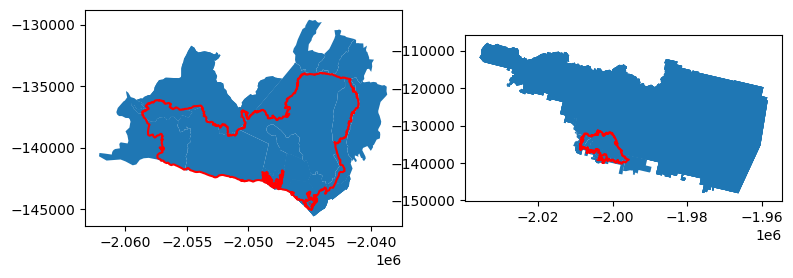

In [43]:
# Initialize plot with two axes, plot eaton and palisades on each
ig, ax = plt.subplots(figsize=(9,5), nrows = 1, ncols = 2)

palisades_tracts.plot(ax = ax[0])

palisades.boundary.plot(ax = ax[0],
                       color = "red")

eaton_tracts.plot(ax = ax[1])

eaton.boundary.plot(ax = ax[1],
                       color = "red")

Palisades fire is way bigger relative to its census tracts than the Eaton fire.

## Polygon clipping

In [ ]:
clipped_palisades = gpd.clip(palisades_tracts, palisades)
clipped_eaton = gpd.clip(eaton_tracts, eaton)

Note: `join(predicate = 'within')` would return same thing as clipping!

<Axes: >

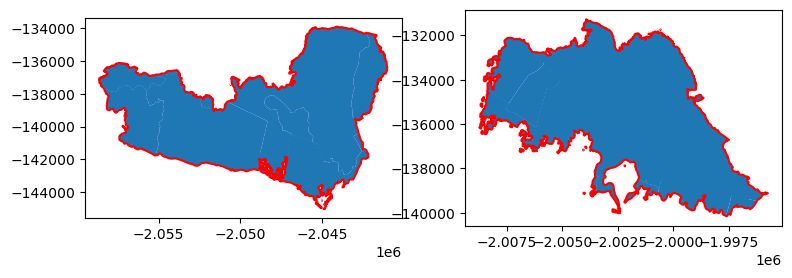

In [47]:
# Initialize plot with two axes, plot eaton and palisades on each
ig, ax = plt.subplots(figsize=(9,5), nrows = 1, ncols = 2)

clipped_palisades.plot(ax = ax[0])

palisades.boundary.plot(ax = ax[0],
                       color = "red")

clipped_eaton.plot(ax = ax[1])

eaton.boundary.plot(ax = ax[1],
                       color = "red")

Difference between clipping and joining: clipping matches geometry up to mask exactly, whereas joining keeps the full polygons of each and returns all that simply intersect (even if not entirely contained).

## Visualize fire perimeters with basemap

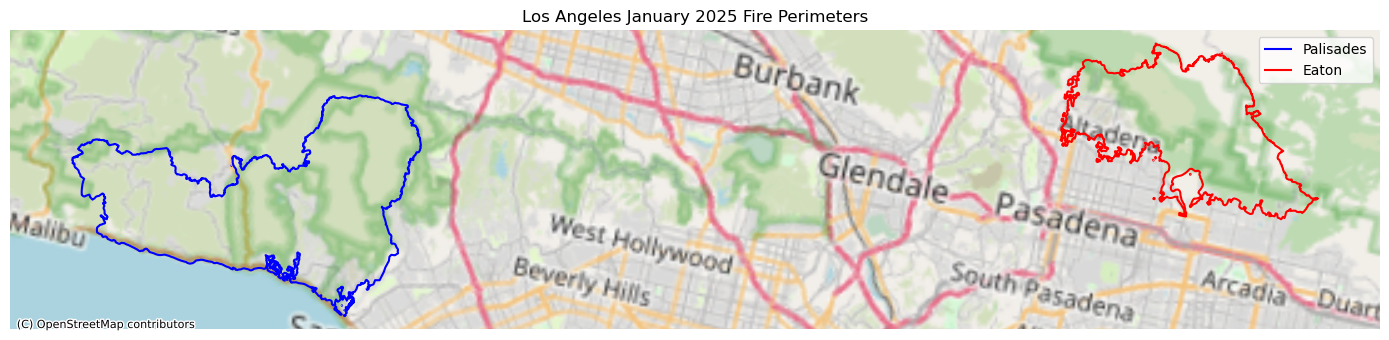

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# ADD FIRE PERIMETERS: UPDATE FILL TRANSPARENCY AND COLOR
palisades.boundary.plot(ax = ax,
                       color = "blue",
                       label = "Palisades")
eaton.boundary.plot(ax = ax,
                   color = "red",
                   label = "Eaton")

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik,
               crs = palisades.crs)


# ADD LEGEND OR ANNOTATION TO IDENTIFY EACH FIRE
plt.legend()

# ADD TITLE
plt.title('Los Angeles January 2025 Fire Perimeters')

ax.axis('off')

plt.tight_layout()
plt.show()

## Visualize EJI Data

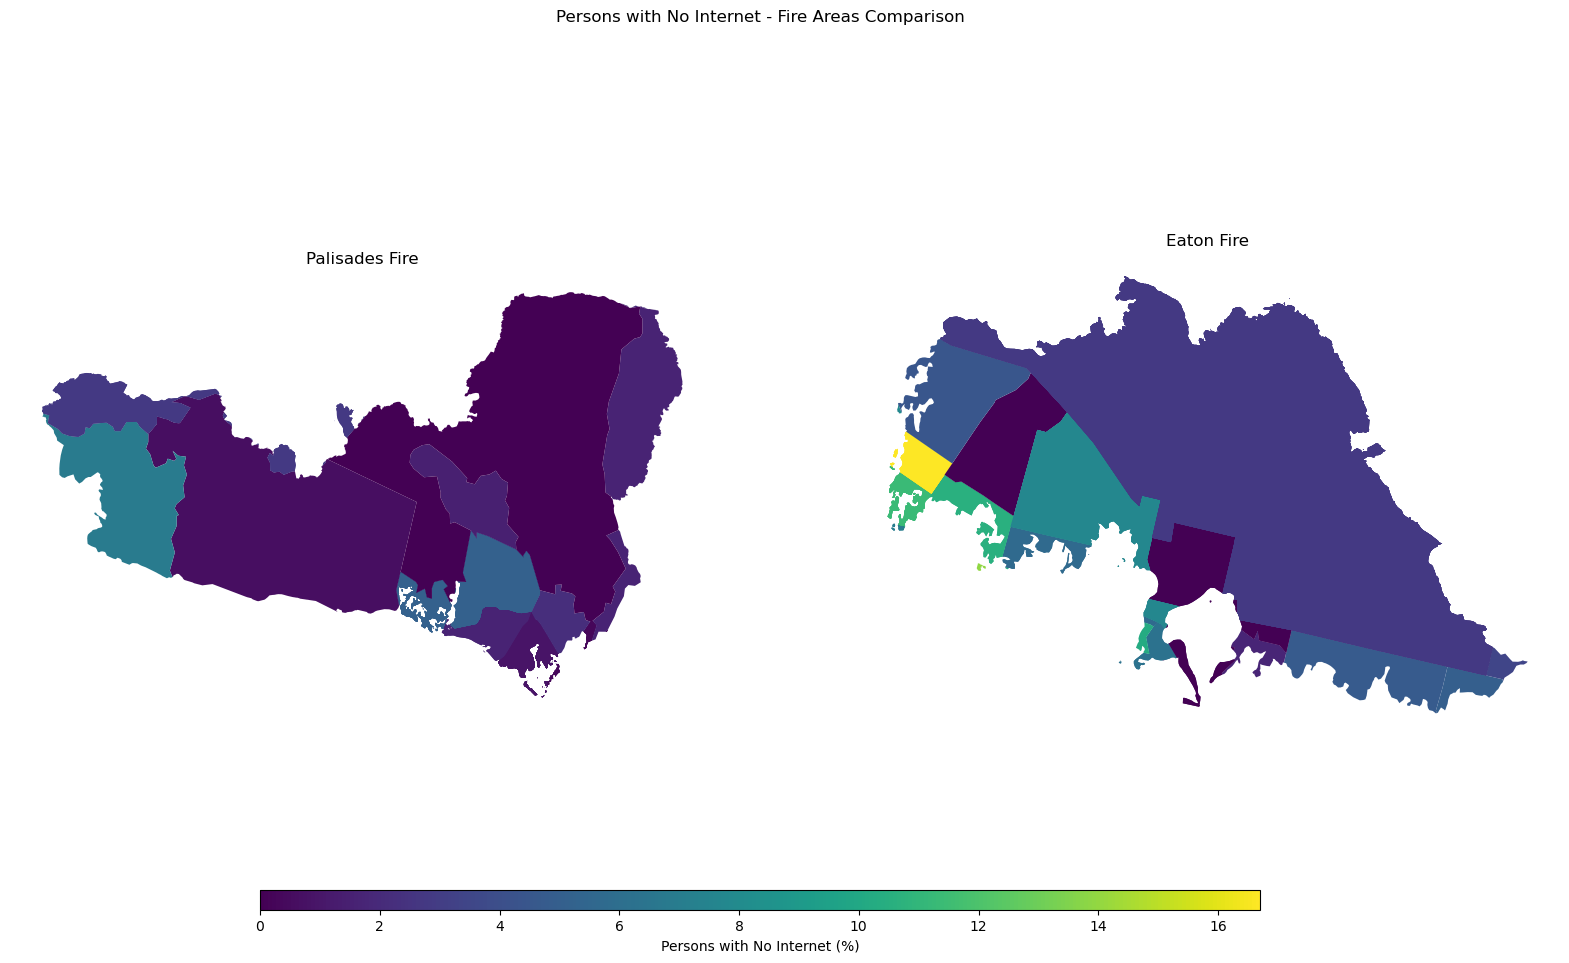

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# UPDATE WITH YOU EJI VARIABLE FROM STEP 1
eji_variable = 'E_NOINT'

# Find common min/max for legend range
vmin = min(clipped_palisades['E_NOINT'].min(), clipped_eaton['E_NOINT'].min())
vmax = max(clipped_palisades['E_NOINT'].max(), clipped_eaton['E_NOINT'].max())

# Plot census tracts within Palisades perimeter
clipped_palisades.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
)
ax1.set_title('Palisades Fire')
ax1.axis('off')

# Plot census tracts within Eaton perimeter
clipped_eaton.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
)
ax2.set_title('Eaton Fire')
ax2.axis('off')

# Add overall title
fig.suptitle('Persons with No Internet - Fire Areas Comparison')

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Persons with No Internet (%)')

plt.show()